In [76]:
from fastai import *
from fastai.vision import *
from fastai.widgets import *
from torch.nn import CrossEntropyLoss

In [2]:
gc.collect()

248

In [43]:
competition = 'datasciencebowl'

In [2]:
#!kaggle competitions download -c datasciencebowl -p {plankton_path}  
#!unzip {path}/sampleSubmission.csv.zip
#!unzip {path}/test.zip
#!unzip {path}/train.zip

In [3]:
plankton_path = Config.data_path()/'plankton'
train_path = plankton_path / 'train'
test_path = plankton_path / 'test'
project_path = pathlib.Path.home()/'PROJEX/competitions_1/plankton'

In [4]:
project_path.exists(), train_path.exists(), test_path.exists()

(True, True, True)

In [5]:
#df_sub = pd.read_csv(plankton_path/'sampleSubmission.csv')

In [27]:
#df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130400 entries, 0 to 130399
Columns: 122 entries, image to unknown_unclassified
dtypes: float64(121), object(1)
memory usage: 121.4+ MB


In [50]:
#df_sub.shape

(130400, 122)

In [7]:
#df_sub.head(1).T[1:].sum()

0    1.0
dtype: float64

It appears that the goal is to produce a csv file with 1 row per image, and columns populated by classes. For a given image, each class is assigned a probability. 

## Data Dealings

The training data set is partitioned into folders names after the classes they belonged to. The table above 122 classes.
The widget FileDeleter was removed in favor of ImageDeleter and ImageRelabeler.



In [9]:
test = ImageList.from_folder(test_path)
data = (ImageDataBunch.from_folder(train_path, train='./', valid_pct=0.2,
                                   ds_tfms=get_transforms(), size=128)
        .normalize(imagenet_stats))

In [10]:
data.classes[:5]

['acantharia_protist',
 'acantharia_protist_big_center',
 'acantharia_protist_halo',
 'amphipods',
 'appendicularian_fritillaridae']

In [11]:
#for c in data.classes:
#    verify_images(train_path/c, )

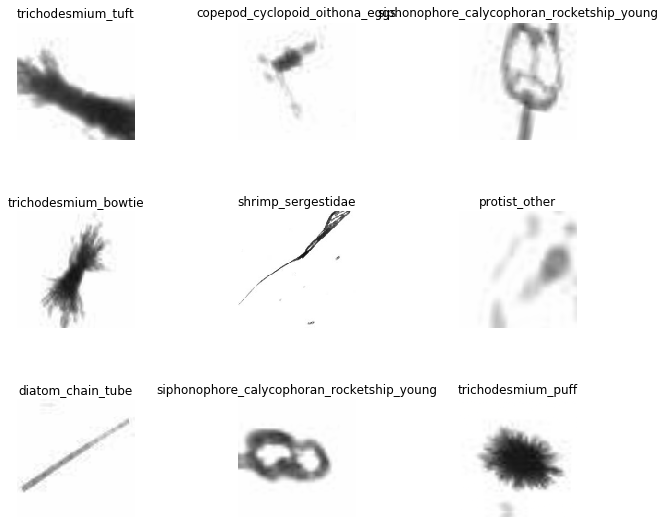

In [13]:
data.show_batch(rows=3, figsize=(9, 8))

In [14]:
data.c, len(data.train_ds), len(data.valid_ds)

(121, 24269, 6067)

In [15]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.loss_func = CrossEntropyLoss()

---
## TRAINING - PART 1
---

### Train model

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


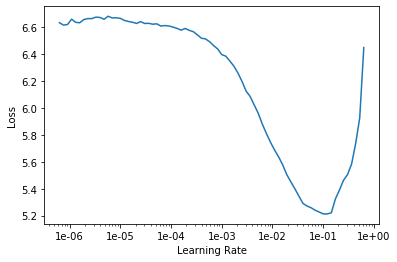

In [17]:
learn.recorder.plot()

In [18]:
lr = 1e-2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,2.199532,1.665838,0.436624,00:45
1,1.616124,1.302838,0.369375,00:44
2,1.408356,1.086662,0.324707,00:45
3,1.207671,0.977664,0.287622,00:44
4,1.080495,0.955682,0.285644,00:45


In [19]:
learn.save(project_path / 'size_128_stage-1')

In [20]:
stat = (project_path/'size_128_stage-1.pth').stat()

In [21]:
print(f'model size: {stat.st_size/int(1e6):.2f}MB')

model size: 92.50MB


---
## END OF TRAINING - PART 1
---

Now I'll give it a first shot with the test set see where that puts me in the leaderboard

In [23]:
test = ImageList.from_folder(test_path)
learn.load(project_path / 'size_128_stage-1');

In [24]:
learn.export(project_path/'export.pkl')

In [25]:
lexp = load_learner(project_path, test=test)

In [26]:
preds, y = lexp.get_preds(ds_type=DatasetType.Test)

In [29]:
images = [image.name for image in lexp.data.test_ds.items]
predictions = np.c_[images, preds.data]
df_pred = pd.DataFrame(predictions, columns=['image']+data.classes, )
df_pred.shape

(130400, 122)

In [30]:
df_pred.head()

,image,acantharia_protist,acantharia_protist_big_center,acantharia_protist_halo,amphipods,appendicularian_fritillaridae,appendicularian_s_shape,appendicularian_slight_curve,appendicularian_straight,artifacts,...,trichodesmium_tuft,trochophore_larvae,tunicate_doliolid,tunicate_doliolid_nurse,tunicate_partial,tunicate_salp,tunicate_salp_chains,unknown_blobs_and_smudges,unknown_sticks,unknown_unclassified
0,124407.jpg,2.4450404e-05,2.6375305e-06,6.568533e-07,2.750672e-05,1.3509094e-05,2.1904998e-05,5.463808e-06,6.0833495e-06,1.3462325e-06,...,2.2952716e-05,1.4285174e-06,5.5778105e-07,4.4085186e-06,8.0519567e-07,3.1707295e-05,1.6483772e-06,0.00033112976,3.669079e-05,0.00013958664
1,51139.jpg,4.446674e-05,1.0554104e-05,2.6693748e-05,0.0010606927,0.00068806345,0.017632375,0.013468125,0.0018385054,0.00040505832,...,0.0034876524,4.3881364e-06,0.00017310545,0.000972049,2.301494e-05,0.00021046276,9.78866e-05,0.030543117,0.020029042,0.0097807245
2,124875.jpg,0.00020773495,7.868878e-07,8.2779725e-06,5.5121916e-07,1.8017403e-06,1.7653023e-05,1.7969064e-06,9.382204e-06,2.5197105e-06,...,3.193254e-08,1.6972748e-05,3.4282722e-05,2.8293298e-05,4.5188935e-07,9.484616e-06,2.34578e-07,5.9148246e-05,8.673727e-06,0.00014837243
3,149162.jpg,0.00018013913,5.6205132e-05,3.2641306e-05,4.299491e-05,0.003926837,0.20631203,0.3102143,0.0029291185,0.00011405041,...,0.0005250601,2.5126204e-05,8.5342166e-05,0.0010216016,0.00011439845,0.00012782904,0.000118282085,0.029204397,0.0046551186,0.0044876817
4,66170.jpg,6.8701316e-05,1.0047851e-06,2.774187e-06,7.338035e-06,3.5948233e-06,4.6087102e-06,6.6563307e-06,2.8562705e-05,5.373052e-06,...,0.00021141846,7.7719335e-07,8.3908515e-07,6.0115644e-07,2.4754052e-06,2.731267e-05,5.572597e-07,0.0001852457,0.00015990605,7.327829e-05


In [31]:
df_pred.set_index('image', drop=True).to_csv(project_path/'submission3.csv')

In [44]:
!kaggle competitions submit {competition} -f {project_path/'submission3.csv'} -m "size_128_frozenmdl_submission"

100%|████████████████████████████████████████| 204M/204M [00:05<00:00, 38.8MB/s]
Successfully submitted to National Data Science Bowl

The above scored 0.9730, which ranks me as 235th out of 1050 on the private leaderboard.

---
## TRAINING - PART 2
---

Now I'll reload stage 1, unfreeze the model and retrain.

In [62]:
235/1050*100

22.380952380952383

In [49]:
test = ImageList.from_folder(test_path)
learn.load(project_path / 'size_128_stage-1');

In [50]:
learn.unfreeze()

In [51]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


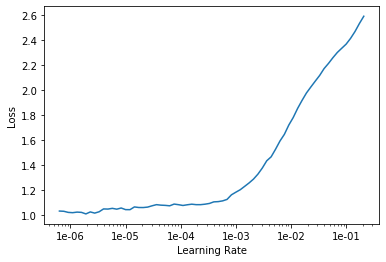

In [52]:
learn.recorder.plot()

In [53]:
learn.fit_one_cycle(5, slice(1e-6, lr/50))

epoch,train_loss,valid_loss,error_rate,time
0,1.077802,0.948145,0.286633,01:01
1,1.047295,0.923077,0.275589,01:01
2,1.022257,0.901046,0.267513,01:02
3,0.914298,0.882981,0.262733,01:01
4,0.949455,0.880684,0.265040,01:01


In [54]:
learn.save('size_128_stage-2')

In [55]:
learn.export(project_path/'export_128_unfr.pkl')

In [56]:
def make_submission(submission_name='submissionX', exported_learner='export.pkl'):
    df_sub = pd.read_csv(plankton_path/'sampleSubmission.csv')
    lexp = load_learner(project_path, file=exported_learner, test=test)
    images = [image.name for image in lexp.data.test_ds.items]
    preds, _ = lexp.get_preds(ds_type=DatasetType.Test)
    predictions = np.c_[images, preds.data]
    df_pred = pd.DataFrame(predictions, columns=['image'] + data.classes)
    df_pred.set_index('image', drop=True).to_csv(project_path/f'{submission_name}')

In [ ]:
make_submission(submission_name='submission4.csv', exported_learner='export_128_unfr.pkl')

In [60]:
submission_message='size_128_unfrozenmdlsubmission',
!kaggle competitions submit {competition} -f {project_path/'submission4.csv'} -m f"{submission_message}"

100%|████████████████████████████████████████| 204M/204M [00:04<00:00, 49.7MB/s]
Successfully submitted to National Data Science Bowl

The above scored 0.88689, through which I went up to 185th our of 1050.

---
## TRAINING - PART 3
---

Here I load a different model, in this case

In [64]:
185/1050*100

17.61904761904762

In [65]:
interp = ClassificationInterpretation.from_learner(learn)

In [67]:
conf_mat = interp.confusion_matrix()

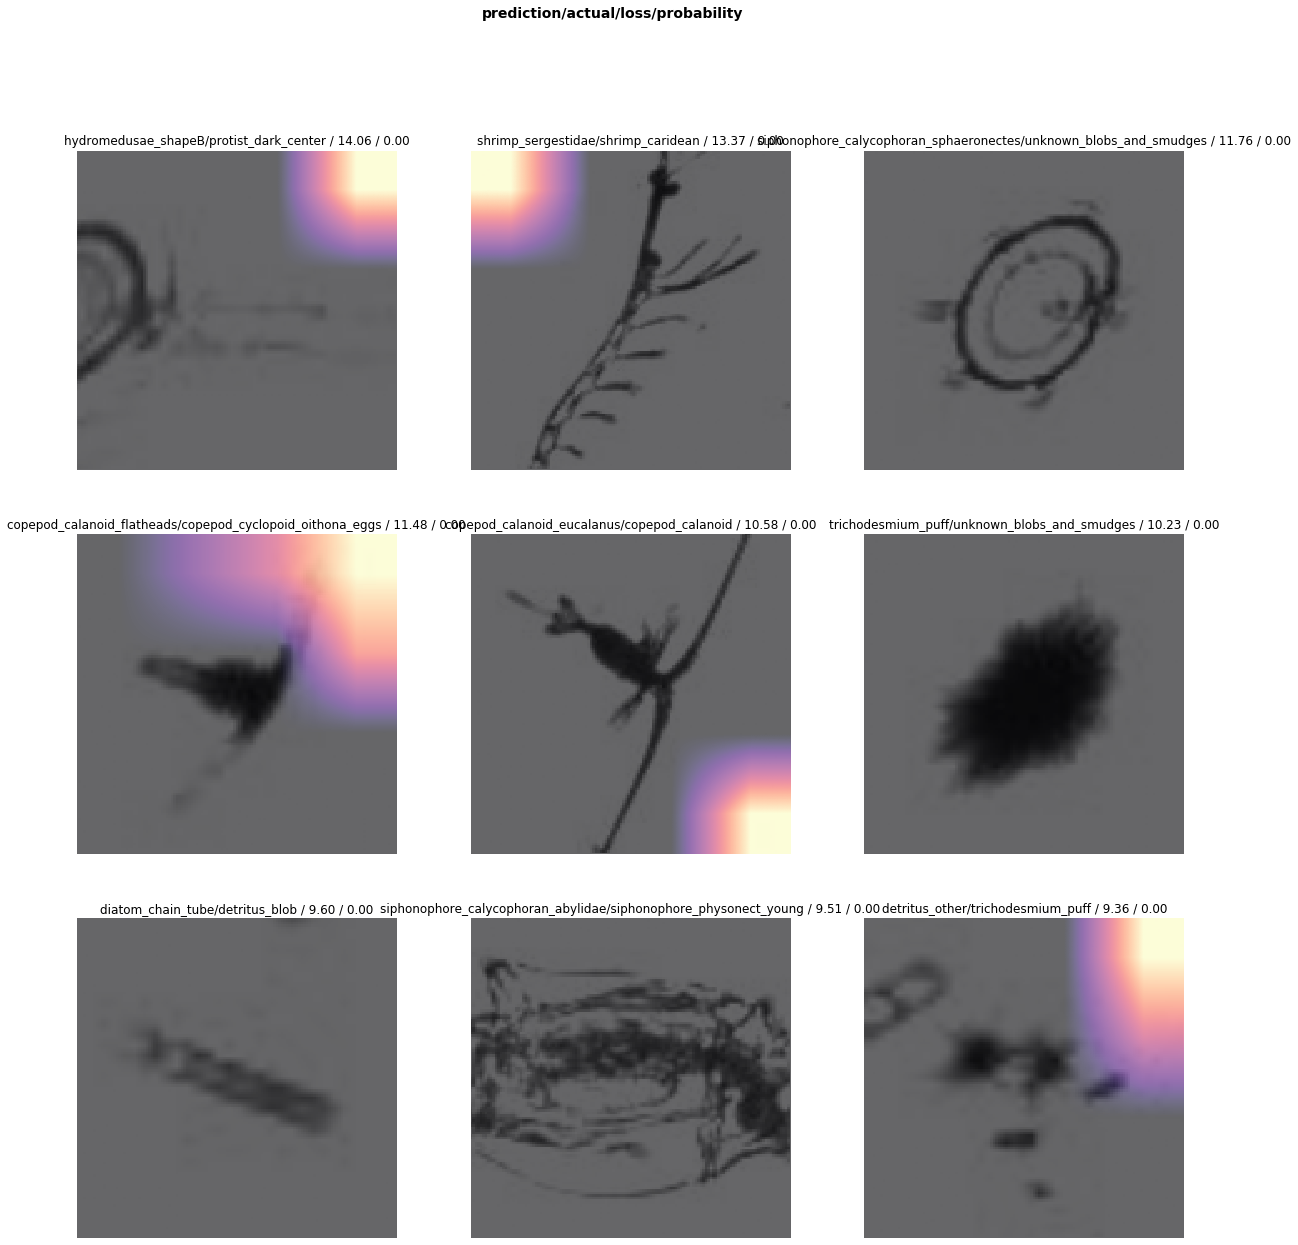

In [66]:
interp.plot_top_losses(9, figsize=(20, 20), heatmap=True)

In [68]:
import matplotlib.pyplot as pl
from seaborn import heatmap

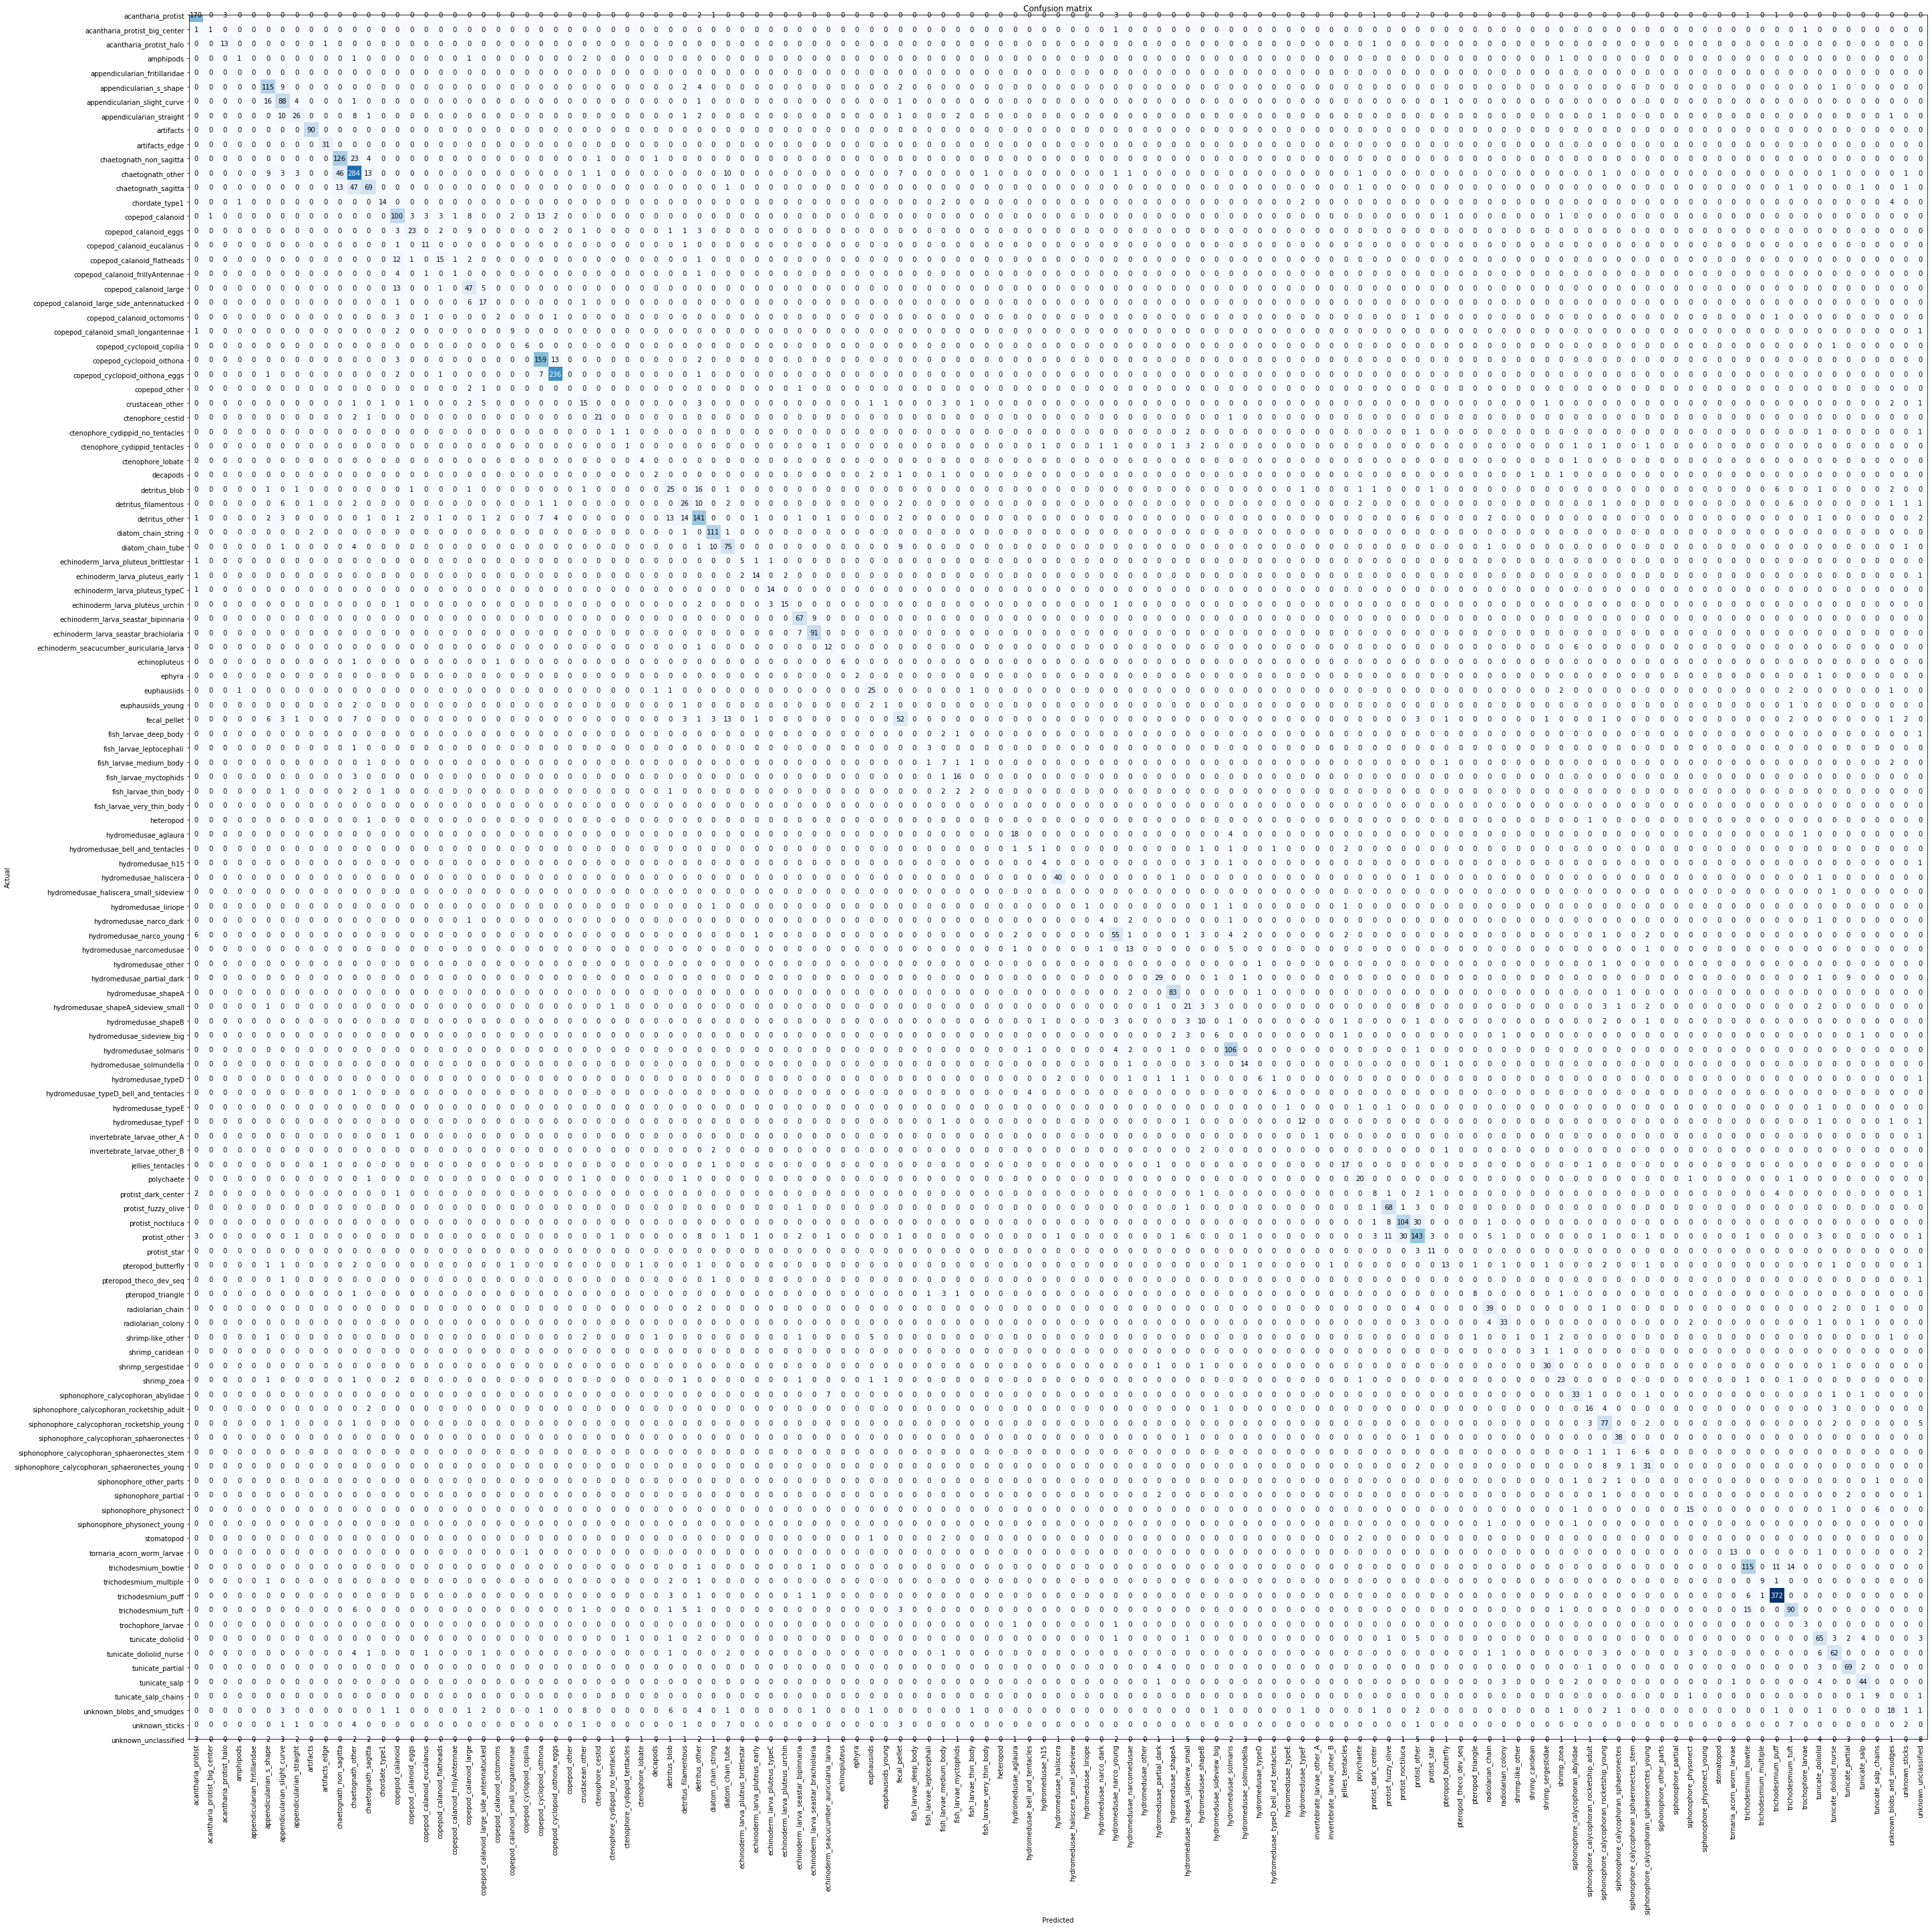

In [79]:
f1= interp.plot_confusion_matrix(figsize=(40, 40), return_fig=True )

In [80]:
f1.savefig('confmat.png', dpi=300)

## Post learning data cleaning

ImageDeleter is essentially the same as the old FileDeleter.

ImageRelabeler renders the files you pass in and lets you re-label them. This is to find mis-categorized images in your data directory. NOTE: ImageRelabeler currently only works with files where labels were created from the names of their parent directory (i.e. with .from_folder()). The widget moves mislabeled photos from the incorrect parent directory to the properly-labeled parent directory.

To relabel an image, just click the proper label in the widget dropdown.

Both widgets take a formatted dataset from DatasetFormatter. You can easily specify which dataset you’d like to render by passing in DatasetType.Valid, DatasetType.Train or DatasetType.Test to the ds_type keyword arg in DatasetFormatter.from_toplosses.

All three classes are available in fastai.widgets.

In [78]:
ds, idxs = DatasetFormatter().from_toplosses(learn)
ImageCleaner(ds, idxs, project_path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())